In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect = True)

In [14]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = base.classes.measurement

Station = base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
recent_date_query = session.query(func.max(Measurement.date), func.count(Measurement.date)).first()
max_date = recent_date_query[0]

print(max_date)


2017-08-23


In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Find the most recent date in the dataset
recent_date_query = session.query(func.max(Measurement.date)).first()
max_date = recent_date_query[0]
print(max_date)

# Calculate the date one year from the last date
starting_date = dt.datetime.strptime(max_date, "%Y-%m-%d").date() - dt.timedelta(days=365)
print(starting_date)

2017-08-23
2016-08-23


In [81]:
precip_date

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

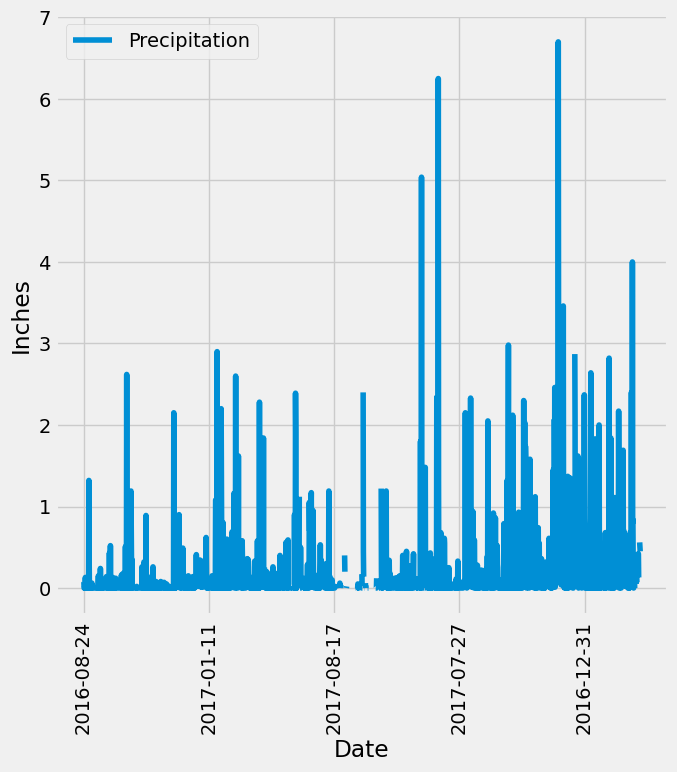

In [55]:
# Perform a query to retrieve the data and precipitation scores
precip_date = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > starting_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
result_df = pd.DataFrame(data=precip_date, columns=["Date", "Precipitation"])


# Sort the dataframe by date
result_df.sort_index(inplace=True)
result_df.set_index("Date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
result_df.plot.line(figsize=(7, 7))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


In [53]:
# Use Pandas to calculate the summary statistics for the precipitation data
result_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [56]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(total_stations)

9


In [57]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

for station, count in station_counts:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [65]:
# Using the most active station id, calculate the lowest, highest, and average temperature.
temp_stats = session.query(func.min(Measurement.tobs).label('min_temp'),
                           func.max(Measurement.tobs).label('max_temp'),
                           func.avg(Measurement.tobs).label('avg_temp')). \
    filter(Measurement.station == most_active_station). \
    first()

# Print the temperature statistics
print("Min temp:", temp_stats.min_temp)
print("Max temp:", temp_stats.max_temp)
print("Avg temp:", temp_stats.avg_temp)

Min temp: 54.0
Max temp: 85.0
Avg temp: 71.66378066378067


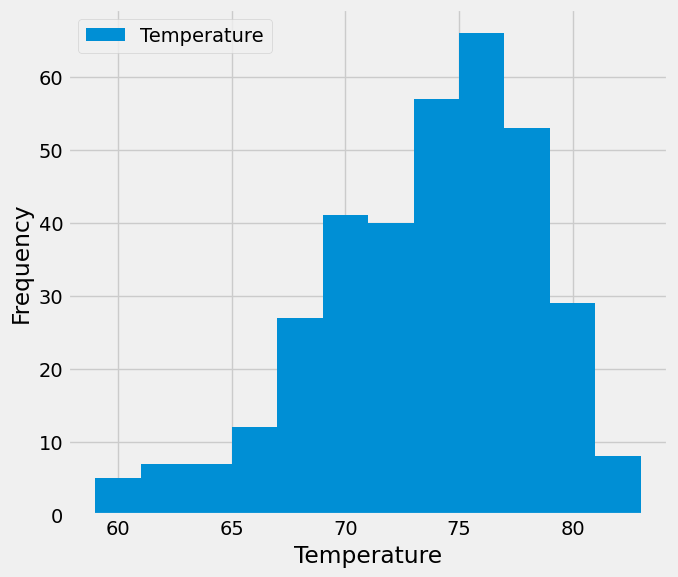

In [78]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_year = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == station_counts[0][0]).\
    filter(Measurement.date >= one_year_ago).all()

temp_year_df = pd.DataFrame(temp_year, columns=["Date", "Temperature"])

temp_year_df.plot.hist(bins=12, figsize=(7, 6))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [72]:
# Close Session
session.close()